# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [5]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

FileNotFoundError: [Errno 2] No such file or directory: '../data/lab-03-data.tar.gz'

## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [6]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../data/lab-03-data/part1/classification.mat'

### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

*Add your implementation and discussion*

### 1.2 Mahalanobis distance
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

*Add your implementation and discussion*

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [7]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [2]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)
print('data loaded')

data loaded


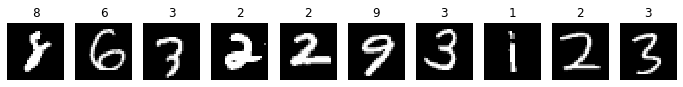

In [3]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP
We use multi layer perceptron classifier class of scikit image to implement MPL classification. We select _adam_ solver 
with _relu_ activation and constant learning rate equal to 0.001. The L2 penalty parameter is selected equal to 0.00001, 
and 100 hidden layers is chosen. Training stops if the difference between loss value in few (i.e 5) consecutive epochs is less
 than a tolerance (i.e 0.001). With these selected hyper-parameters we could achieve training accuracy of 98.74 percent and
 test accuracy equal to 96.37 percent in 33 epochs.

In [4]:
X_train = train_images.reshape(train_images.shape[0],784)
X_test = test_images.reshape(test_images.shape[0],784)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(verbose=True, solver='adam', activation='relu', learning_rate='constant', alpha=1e-5, hidden_layer_sizes=100, random_state=1, n_iter_no_change=5, tol=1e-3, learning_rate_init=0.001)
clf.fit(X_train, train_labels)
print("Training set score: {:2.2f} %".format(100*clf.score(X_train, train_labels)))
print("Test set score: {:2.2f} %".format(100*clf.score(X_test, test_labels)))

Iteration 1, loss = 5.93003001
Iteration 2, loss = 1.28263621
Iteration 3, loss = 0.73208031
Iteration 4, loss = 0.46808069
Iteration 5, loss = 0.30832304
Iteration 6, loss = 0.22724818
Iteration 7, loss = 0.18512574
Iteration 8, loss = 0.15689195
Iteration 9, loss = 0.13362738
Iteration 10, loss = 0.12055225
Iteration 11, loss = 0.11651073
Iteration 12, loss = 0.11198416
Iteration 13, loss = 0.09504580
Iteration 14, loss = 0.09049221
Iteration 15, loss = 0.08311093
Iteration 16, loss = 0.08027469
Iteration 17, loss = 0.10354868
Iteration 18, loss = 0.09123970
Iteration 19, loss = 0.08033255
Iteration 20, loss = 0.07468981
Iteration 21, loss = 0.07784560
Iteration 22, loss = 0.06960970
Iteration 23, loss = 0.07200417
Iteration 24, loss = 0.08149329
Iteration 25, loss = 0.06870388
Iteration 26, loss = 0.06524406
Iteration 27, loss = 0.05095022
Iteration 28, loss = 0.07785403
Iteration 29, loss = 0.07892926
Iteration 30, loss = 0.05302436
Iteration 31, loss = 0.05660440
Iteration 32, los

In order to analyse the effect of the learning rate, the learning rate was decreased to 0.0001, and it is shown that
the training accuracy improves to 99.59 percent whereas test accuracy decreases to 95.30 percent. Number of epochs to satisfy the same
stopping criteria also increased to 50 iterations. Therefore, we can conclude that reducing the learning rate too much can cause 
overfitting, and it generally increases the number of iteration to diminish loss.

In [27]:
X_train = train_images.reshape(train_images.shape[0],784)
X_test = test_images.reshape(test_images.shape[0],784)
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(verbose=True, solver='adam', activation='relu', learning_rate='constant', alpha=1e-5, hidden_layer_sizes=100, random_state=1, n_iter_no_change=5, tol=1e-3, learning_rate_init=0.0001)
clf.fit(X_train, train_labels)
print("Training set score: {:2.2f} %".format(100*clf.score(X_train, train_labels)))
print("Test set score: {:2.2f} %".format(100*clf.score(X_test, test_labels)))



Iteration 1, loss = 21.70459749
Iteration 2, loss = 5.74775252
Iteration 3, loss = 3.85840640
Iteration 4, loss = 2.89654914
Iteration 5, loss = 2.32115447
Iteration 6, loss = 1.91895766
Iteration 7, loss = 1.61555094
Iteration 8, loss = 1.36590733
Iteration 9, loss = 1.17816861
Iteration 10, loss = 1.01917615
Iteration 11, loss = 0.89280216
Iteration 12, loss = 0.77249974
Iteration 13, loss = 0.67705171
Iteration 14, loss = 0.59023665
Iteration 15, loss = 0.52018382
Iteration 16, loss = 0.46500461
Iteration 17, loss = 0.40212731
Iteration 18, loss = 0.35216358
Iteration 19, loss = 0.30990761
Iteration 20, loss = 0.27517889
Iteration 21, loss = 0.23865399
Iteration 22, loss = 0.20815477
Iteration 23, loss = 0.18531479
Iteration 24, loss = 0.16053542
Iteration 25, loss = 0.14483375
Iteration 26, loss = 0.12918576
Iteration 27, loss = 0.10981550
Iteration 28, loss = 0.09998642
Iteration 29, loss = 0.09025708
Iteration 30, loss = 0.07329900
Iteration 31, loss = 0.06723395
Iteration 32, lo